# Pronóstico adaptativo

## Descripción del problema real

Los pronósticos de los precios de la electricidad en mercados liberalizados son un insumo fundamental para la toma de decisiones dentro de las organizaciones. Fundamentalmente, los pronosticos de corto plazo son utilizados en decisiones de carácter operativo. En el caso abordado, es necesario contar con los pronósticos para definir la politica de operación de una empresa del sector eléctrico.

## Descripción del problema en términos de los datos

La carpeta `datos/precios/` contiene los precios historicos horarios de la electricidad en la Bolsa de Energía del mercado eléctrico colombiano, publicados por el operador del mercado. Se desean obtener pronósticos para el precio promedio diario para los próximos siete (7) días a la fecha actual.

## Aproximaciones posibles

En este caso, se desea evaluar la capacidad de pronóstico de un ADALINE con aprendizaje en línea.

## Requerimientos

Usted debe:

* Procesar los datos históricos para conformar el conjunto de datos. Los archivos de Excel no pueden ser modificados y actualizados directamente por el operador del sistema. Su código debe leer los archivos y crear la serie de precios promedio diarios de la electricidad.


* Determinar si el modelo debe pronosticar los precios promedios sin ninguna transformación, o si la inclusión de una transformación (logaritmo natural, raíz cúbica, raíz cuadrada, etc) resulta en un incremento de la precisión del pronóstico.


* Generar el pronóstico para los precios de los próximos siete días.


* Preparar el código para que el modelo sea entrenado usando el gradiente y el momentum.


* Determinar cuál es el número óptimo de retardos (observaciones) que el modelo debe considerar hacia atrás para producir el pronóstico.


* Determinar los valores óptimos de la tasa de aprendizaje y el momentum.


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn import metrics
import keras as ke
import glob

Using TensorFlow backend.


<p><strong><span style="font-size: 24px;">Aqu&iacute; leemos los datos de todas las carpetas y los cargamos en un DataFrame</span></strong></p>

In [2]:
Hojas = []
for i in glob.glob("datos/precios/*"):
    Hojas.append(i)
Precios = pd.read_excel(Hojas[0], skiprows = 3)

In [3]:
for i in range(1,len(Hojas)):    
    aux = 0    
    while(True):         
        precio_i = pd.read_excel(Hojas[i],skiprows = aux).iloc[:,0:25]          
        if precio_i.columns[0] == 'Fecha':
            break
        else:
            aux+=1
    Precios = pd.concat([Precios, precio_i], ignore_index= True, axis=0)

<p><span style="font-size: 
      22px;"><strong>Se organizan los datos por fecha y luego se normalizan los datos para su posterior an&aacute;lisis.</strong></span></p>

<p>Si se desean ver las gr&aacute;ficas para confirmas que los grupos de datos, con y sin normalizan, sin iguales se le puede quitar el comentario a las lineas plt.</p>

In [4]:
Precios["Fecha"] = pd.to_datetime(Precios["Fecha"])
Precios = Precios.sort_values(by=["Fecha"])
Plot = pd.concat([Precios["Fecha"], Precios.mean(axis=1, numeric_only = True)],axis = 1)
Plot = Plot.dropna()
#plt.figure(num = None, figsize =(20,10))
#plt.plot(Plot["Fecha"], Plot.iloc[:,1], linewidth = 0.5)
#plt.show()

In [5]:
Plot = Plot.reset_index(drop=True)
Plot.columns = ["Fecha","Precio"]
Plot["Precio"]=(Plot["Precio"]-Plot["Precio"].min())/(Plot["Precio"].max()-Plot["Precio"].min())
#plt.figure(num = None, figsize =(20,10))
#plt.plot(Plot["Fecha"], Plot.iloc[:,1], linewidth = 0.5)
#plt.show()

<p>Peque&ntilde;a prueba para ver si esta corriendo el tensorflow o no, en versiones anteriores no esta corriendo por defecto.</p>

In [37]:
if tf.executing_eagerly() == False:
    tf.enable_eager_execution()

<p><strong><span style="font-size: 
      26px;">Creamos todas las funciones que vamos a utilizar de ahora en adelante</span></strong></p>

<p><strong>- Funci&oacute;n SacarRetardo:</strong> elige que retardos son los m&aacute;s &oacute;ptimos.</p>
<p><strong>- Funci&oacute;n SacarTasa: </strong>elige que tasa de aprendizaje es la m&aacute;s &oacute;ptima.<br><strong><br>- Funci&oacute;n adaline: </strong>funci&oacute;n adaline para los d&iacute;as pedidos.&nbsp;</p>
<p><strong>- Funci&oacute;n Graficar:</strong> esta funci&oacute;n muestra que tan cerca es una predicci&oacute;n a la realidad. Tambien muestra el MSE en pantalla.&nbsp;</p>

In [8]:
class Model(object):
    def __init__(self, L):
        self.w = tf.Variable([0.0] * (L))

    def __call__(self, x):
        x = tf.constant(np.array([1.0] + x, dtype=np.float32))
        y_pred = tf.reduce_sum(tf.multiply(self.w, x))
        return y_pred

    def fit(self, mu, x, y_desired):
        y_pred = self(x)
        e = y_desired - y_pred
        x = tf.constant(np.array([1.0] + x, dtype=np.float32))
        self.w.assign_add(tf.scalar_mul(2 * mu * e, x))

def SacarRetardo(Prueba,aux):  
    Retardos = []
    
    for i in range(len(Prueba)):
        L = Prueba[i]
        model = Model(L)
        y_pred = np.empty(len(aux))
        y_pred[:] = np.nan
        
        for t in range(L, len(aux)):
            x = aux[t-L:t]
            y_pred[t] = model(x)
            model.fit(mu=0.05, x=x, y_desired=aux[t])
            
        Retardos.append([aux[-(24*7):],y_pred[-(24*7):]]) 
    return Retardos

def SacarTasa(Prueba2,Aux2):
    Tasas = []

    for i in range(len(Prueba2)):    
        L = 7
        model = Model(L)
        y_pred = np.empty(len(Aux2))
        y_pred[:] = np.nan

        for t in range(L, len(Aux2)):
            x = Aux2[t-L:t]
            y_pred[t] = model(x)
            model.fit(mu=Prueba2[i], x=x, y_desired=Aux2[t])

        Tasas.append([Aux2[-(24*7):],y_pred[-(24*7):]])
    return Tasas

def adaline(Ret,Tasa,d):
    Ret = Ret
    model = Model(Ret)
    y_pred = np.empty(len(d))
    y_pred[:] = np.nan

    for t in range(Ret, len(d)):
        x = d[t-Ret:t]
        y_pred[t] = model(x)
        model.fit(mu=Tasa, x=x, y_desired=d[t])
    
    return [d[-(24*7):],y_pred[-(24*7):]]

def Graficar (Real, Pred):
    plt.figure(figsize=(23,7))
    plt.ylabel("Precio")
    plt.plot(Real, color="black", label="Real")
    plt.plot(Pred, color="red", label="Predicción")
    plt.xlabel('Dias en horas \n \n'+
              'MSE: '+str(metrics.mean_squared_error(Real, Pred)))
    plt.legend()
    plt.show()

<p><strong><span style="font-size: 
      22px;">Aqu&iacute; vamos a calcular los retardos y tasas de aprendizaje mas &oacute;ptimos para el modelo.</span></strong></p>

In [9]:
aux = (Plot.iloc[:,1].values.reshape(-1,1)).reshape(-1,)
Prueba = [2,3,4,5,6,7,6,7,8,9,10,11]
Prueba2 = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09]

In [10]:
RetardosTotal = SacarRetardo(Prueba,aux)
MejorRetardo = []
for i in RetardosTotal:
    MejorRetardo.append(metrics.mean_squared_error(i[0],i[1]))

In [11]:
A = MejorRetardo.index(min(MejorRetardo))
Ret= Prueba[A]

In [12]:
TasaTotal = SacarTasa(Prueba2,aux)
MejorTasa = []
for i in TasaTotal:
    MejorTasa.append(metrics.mean_squared_error(i[0],i[1]))

In [13]:
B = MejorTasa.index(min(MejorTasa))
Tasa = Prueba2[B]

In [14]:
Ada = adaline(Ret,Tasa,aux)

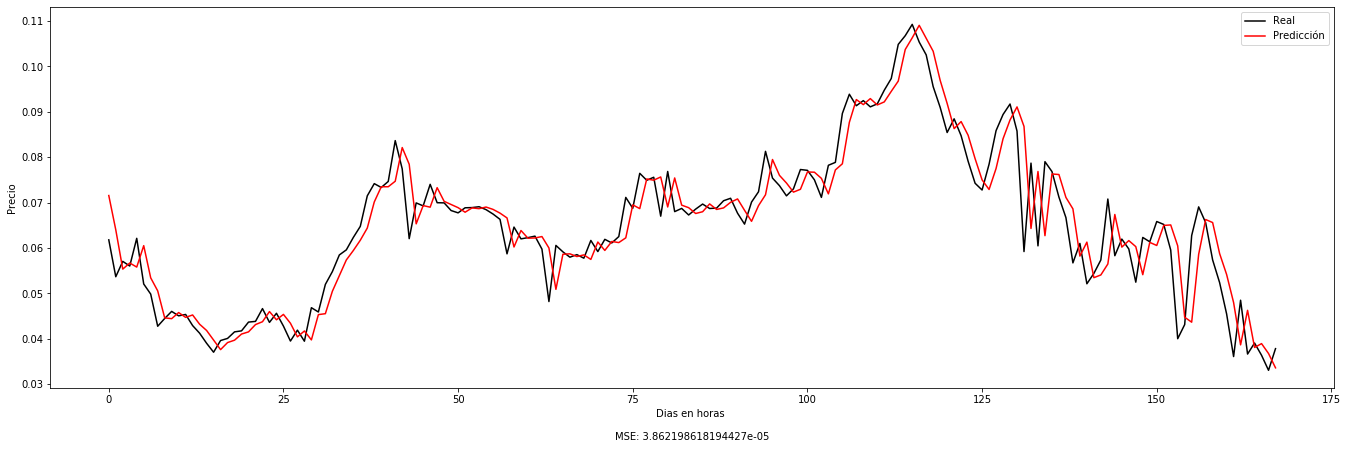

In [15]:
Graficar(Ada[0],Ada[1])

<p><span style="font-size: 
      26px;"><strong>Ahora empezaremos a aplicar las transformaciones.</strong></span></p>

<p><span style="font-size: 
      20px;">1. Transformaci&oacute;n ra&iacute;z cuadrada</span></p>

In [16]:
PlotRaiz = pd.concat([Precios["Fecha"], Precios.mean(axis=1, numeric_only = True)],axis = 1)
PlotRaiz = PlotRaiz.dropna()
PlotRaiz = PlotRaiz.reset_index(drop=True)
PlotRaiz.columns = ["Fecha","Precio"]
PlotRaiz["Precio"]=(PlotRaiz["Precio"].apply(np.sqrt))
PlotRaiz["Precio"]=(PlotRaiz["Precio"]-PlotRaiz["Precio"].min())/(PlotRaiz["Precio"].max()-PlotRaiz["Precio"].min())

In [17]:
Prueba = [2,3,4,5,6,7,6,8,9]
Prueba2 = [0.01,0.02,0.03,0.04,0.05,0.06,0.07]

In [18]:
RetardosRaiz = SacarRetardo(Prueba, PlotRaiz["Precio"].to_numpy())

In [19]:
MejorRetardoRaiz = []
for i in RetardosRaiz:
    MejorRetardoRaiz.append(metrics.mean_squared_error(i[0],i[1]))
A = MejorRetardoRaiz.index(min(MejorRetardoRaiz))
Ret= Prueba[A]

In [20]:
TasaRaiz = SacarTasa(Prueba2,PlotRaiz["Precio"].to_numpy())

In [21]:
MejorTasaRaiz = []
for i in TasaRaiz:
    MejorTasaRaiz.append(metrics.mean_squared_error(i[0],i[1]))
B = MejorTasa.index(min(MejorTasa))
Tasa = Prueba2[B]

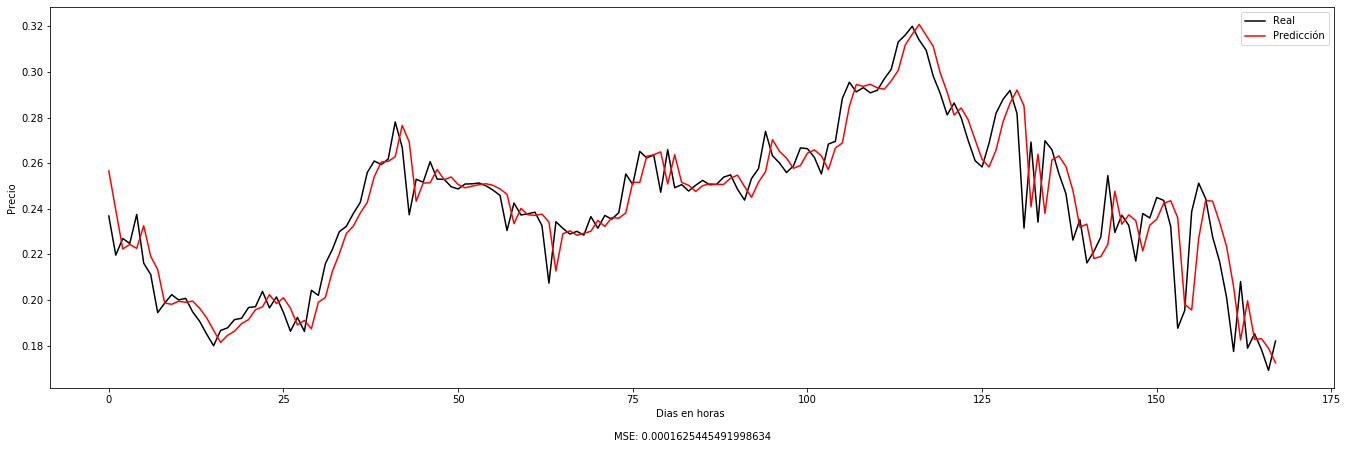

In [22]:
RaizAda = adaline(Ret,Tasa,PlotRaiz["Precio"].to_numpy())
Graficar(RaizAda[0],RaizAda[1])

<p><span style="font-size: 
      20px;">2. Transformaci&oacute;n ra&iacute;z c&uacute;bica</span></p>

In [23]:
PlotRaiz1 = pd.concat([Precios["Fecha"], Precios.mean(axis=1, numeric_only = True)],axis = 1)
PlotRaiz1 = PlotRaiz.dropna()
PlotRaiz1 = PlotRaiz.reset_index(drop=True)
PlotRaiz1.columns = ["Fecha","Precio"]
PlotRaiz1["Precio"]=(PlotRaiz["Precio"].apply(np.cbrt))
PlotRaiz1["Precio"]=(PlotRaiz["Precio"]-PlotRaiz["Precio"].min())/(PlotRaiz["Precio"].max()-PlotRaiz["Precio"].min())

In [24]:
Prueba1 = [2,3,4,5,6,7]
Prueba21 = [0.01,0.02,0.03,0.04,0.05,0.06]

In [25]:
RetardosRaiz1 = SacarRetardo(Prueba1, PlotRaiz1["Precio"].to_numpy())

In [26]:
MejorRetardoRaiz1 = []
for i in RetardosRaiz1:
    MejorRetardoRaiz1.append(metrics.mean_squared_error(i[0],i[1]))
A = MejorRetardoRaiz1.index(min(MejorRetardoRaiz1))
Ret= Prueba1[A]

In [27]:
TasaRaiz1 = SacarTasa(Prueba21,PlotRaiz1["Precio"].to_numpy())

In [28]:
MejorTasaRaiz1 = []
for i in TasaRaiz1:
    MejorTasaRaiz1.append(metrics.mean_squared_error(i[0],i[1]))
B = MejorTasaRaiz1.index(min(MejorTasaRaiz1))
Tasa = Prueba21[B]

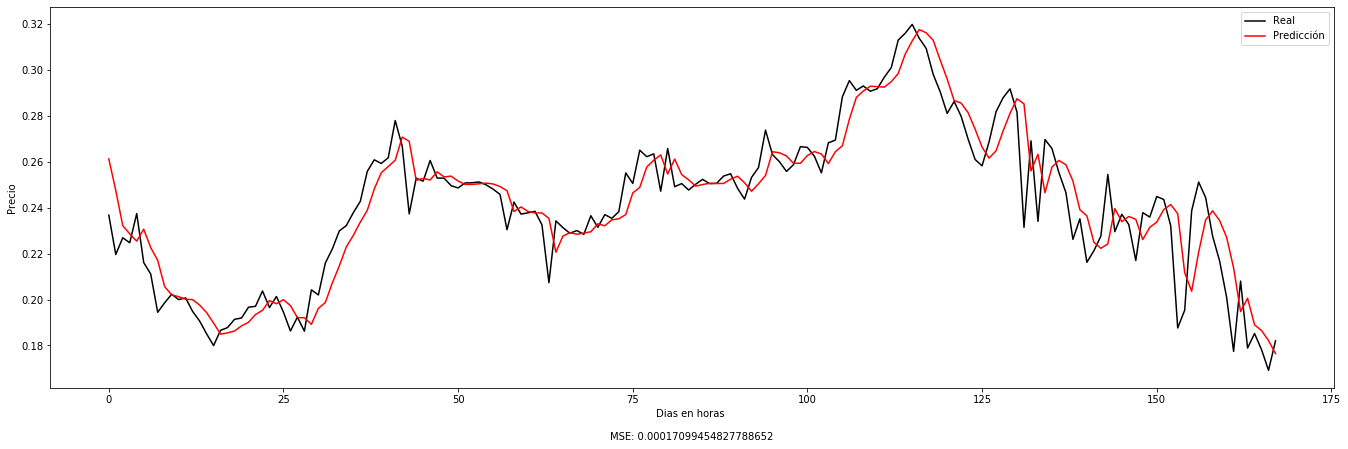

In [29]:
RaizAda1 = adaline(Ret,Tasa,PlotRaiz1["Precio"].to_numpy())
Graficar(RaizAda1[0],RaizAda1[1])

<p><span style="font-size: 
      20px;">3. Transformaci&oacute;n logaritmo</span></p>

In [30]:
PlotRaiz2 = pd.concat([Precios["Fecha"], Precios.mean(axis=1, numeric_only = True)],axis = 1)
PlotRaiz2 = PlotRaiz.dropna()
PlotRaiz2 = PlotRaiz.reset_index(drop=True)
PlotRaiz2.columns = ["Fecha","Precio"]
PlotRaiz2["Precio"]=(PlotRaiz["Precio"].apply(np.log))
PlotRaiz2["Precio"]=(PlotRaiz["Precio"]-PlotRaiz["Precio"].min())/(PlotRaiz["Precio"].max()-PlotRaiz["Precio"].min())

In [31]:
Prueba2 = [2,3,4,5,6]
Prueba22 = [0.01,0.02,0.03,0.04]

In [32]:
RetardosRaiz2 = SacarRetardo(Prueba2, PlotRaiz2["Precio"].to_numpy())

In [33]:
MejorRetardoRaiz2 = []
for i in RetardosRaiz2:
    MejorRetardoRaiz2.append(metrics.mean_squared_error(i[0],i[1]))
A = MejorRetardoRaiz2.index(min(MejorRetardoRaiz2))
Ret= Prueba2[A]

In [34]:
TasaRaiz2 = SacarTasa(Prueba22,PlotRaiz2["Precio"].to_numpy())

In [35]:
MejorTasaRaiz2 = []
for i in TasaRaiz2:
    MejorTasaRaiz2.append(metrics.mean_squared_error(i[0],i[1]))
B = MejorTasaRaiz2.index(min(MejorTasaRaiz2))
Tasa = Prueba22[B]

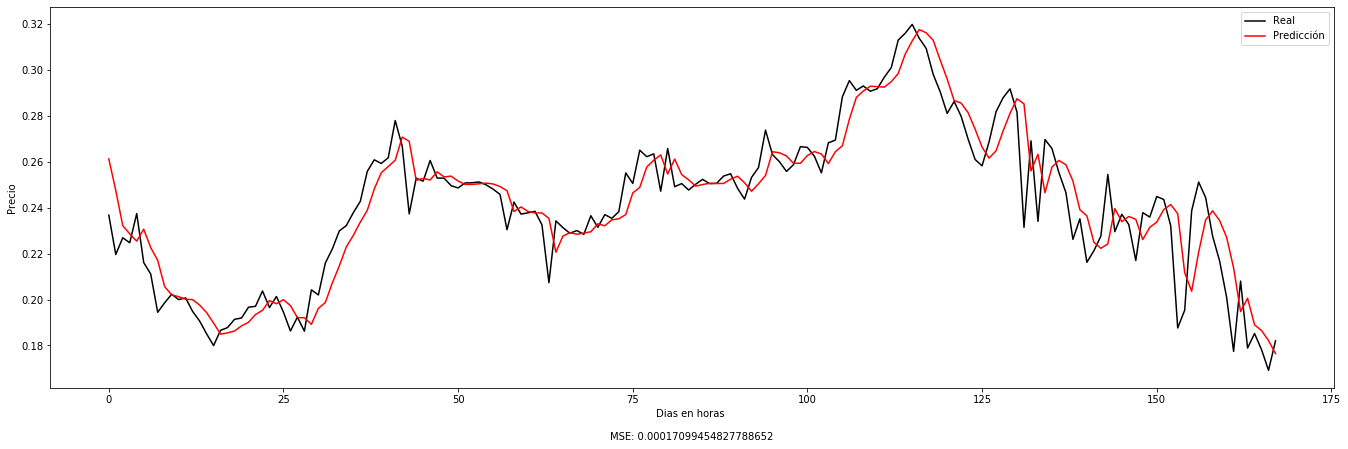

In [36]:
RaizAda2 = adaline(Ret,Tasa,PlotRaiz2["Precio"].to_numpy())
Graficar(RaizAda2[0],RaizAda2[1])

<p><strong><span style="font-size: 
      22px;">Conclusiones</span></strong></p>
<div id="gtx-trans" style="position: absolute; left: -16px; top: 44px;">
    <div class="gtx-trans-icon"></div>
</div>

MSE

- Sin transformar =  3.8621986e-05

- Raiz cuadrada = 0.000162544

- Raiz cúbica = 0.00017099454

- Logaritmo = 0.000170994548

<p>Se aprecia f&aacute;cilmente como las transformaciones sobre los datos no hacen que el MSE sea menor. Es decir, si tomamos los datos sin transformar vamos a tener una predicci&oacute;n de los precios mas cercana a la realidad que aplic&aacute;ndole transformaciones a los datos.</p>
<p>El MSE es muy peque&ntilde;o para esta predicci&oacute;n, esto nos dice que el adaline es un bueno modelo de predicci&oacute;n para este problema en especifico, algo que tambi&eacute;n se puede ver en las 4 gr&aacute;ficas antes mostradas.</p>